In [ ]:
# ================ 1) Imports & Setup ================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ML
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

# Plot settings
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.grid"] = True

# ================ 2) Load Data ================
df = pd.read_csv("youtube.csv")

# Quick sanity
print(df.shape)
print(df.dtypes)

# Parse datetime
df["Video Publish Time"] = pd.to_datetime(df["Video Publish Time"], errors="coerce")

# Basic integrity check
assert df["ID"].is_unique, "IDs should be unique."


(364, 70)
ID                           int64
Video Duration             float64
Video Publish Time          object
Days Since Publish           int64
Day                          int64
                            ...   
Watch Time (hours)         float64
Subscribers                float64
Estimated Revenue (USD)    float64
Impressions                float64
Video Thumbnail CTR (%)    float64
Length: 70, dtype: object


In [ ]:
# ================ 3) Basic Cleaning & Derived Columns ================
# 3.1 Time features
df["publish_date"] = df["Video Publish Time"].dt.date
df["publish_hour"] = df["Video Publish Time"].dt.hour
df["publish_dow"] = df["Day of Week"].astype(str)  # already categorical
df["publish_month"] = df["Month"].astype(int)
df["publish_year"]  = df["Year"].astype(int)

# 3.2 Retention & funnel ratios (robust to divide-by-zero)
def safe_div(a, b):
    a = pd.Series(a.astype(float))
    b = pd.Series(b.astype(float))
    return np.where(b==0, 0.0, a/b)

# Core columns (short names)
views     = "Views"
watch_hr  = "Watch Time (hours)"
avd       = "Average View Duration"           # seconds (assumed)
avp       = "Average View Percentage (%)"     # percent (0-100)
ctr       = "Video Thumbnail CTR (%)"
impr      = "Impressions"
rev_est   = "Estimated Revenue (USD)"

df["watch_minutes_per_view"] = safe_div(df[watch_hr] * 60, df[views])
df["avg_view_pct"]           = df[avp]
df["avg_view_dur_sec"]       = df[avd]

# Normalize retention by content length (if duration > 0)
df["duration_minutes"] = df["Video Duration"].astype(float)
df["retention_vs_length"] = safe_div(df["avg_view_dur_sec"]/60, df["duration_minutes"])

# Monetization funnel
df["ctr_ratio"]            = df[ctr] / 100.0   # percent -> ratio
df["impr_to_view_rate"]    = safe_div(df[views], df[impr])    # realized views per impression
df["views_per_unique"]     = safe_div(df["Views"], df["Unique Viewers"])
df["revenue_per_view"]     = safe_div(df[rev_est], df[views])
df["watch_time_per_view_h"] = safe_div(df[watch_hr], df[views])

# Engagement
df["engagement_count"] = df["Likes"] + df["Shares"] + df["New Comments"]
df["engagement_rate_pct"] = 100 * safe_div(df["engagement_count"], df["Views"])

# Ad monetization depth checks
df["ads_rev_ratio"] = safe_div(
    df["YouTube Ads Revenue (USD)"],
    df[rev_est]
)
df["premium_rev_ratio"] = safe_div(
    df["YouTube Premium (USD)"],
    df[rev_est]
)
df["transaction_rev_ratio"] = safe_div(
    df["Transaction Revenue (USD)"],
    df[rev_est]
)

# CPM sanity: RPM ~ revenue per 1000 views
df["rpm_calc_usd"] = 1000 * df["revenue_per_view"]  # Estimated Revenue basis



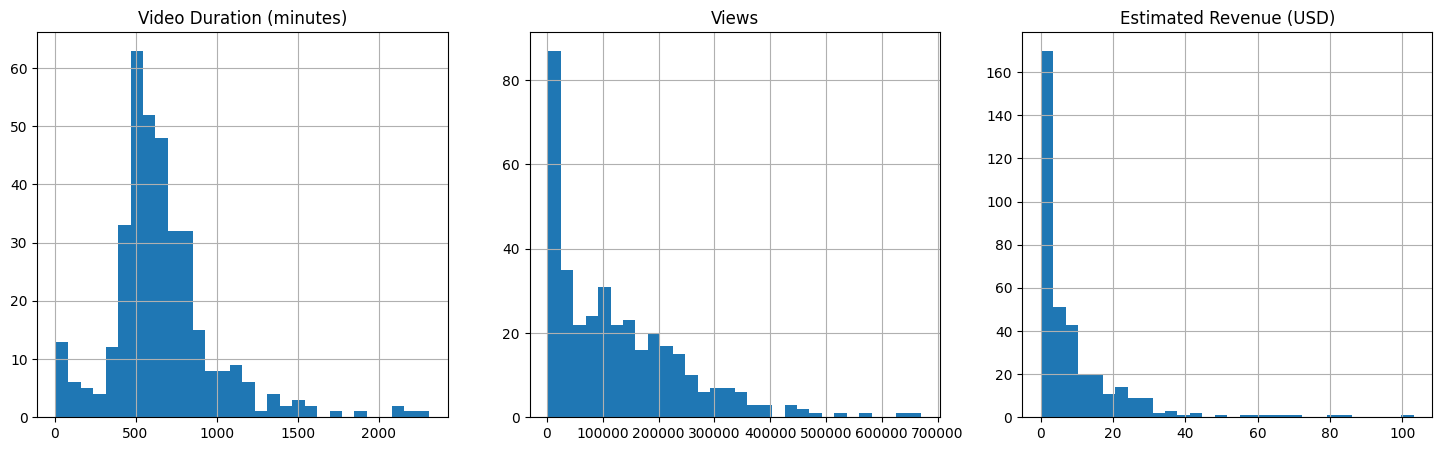

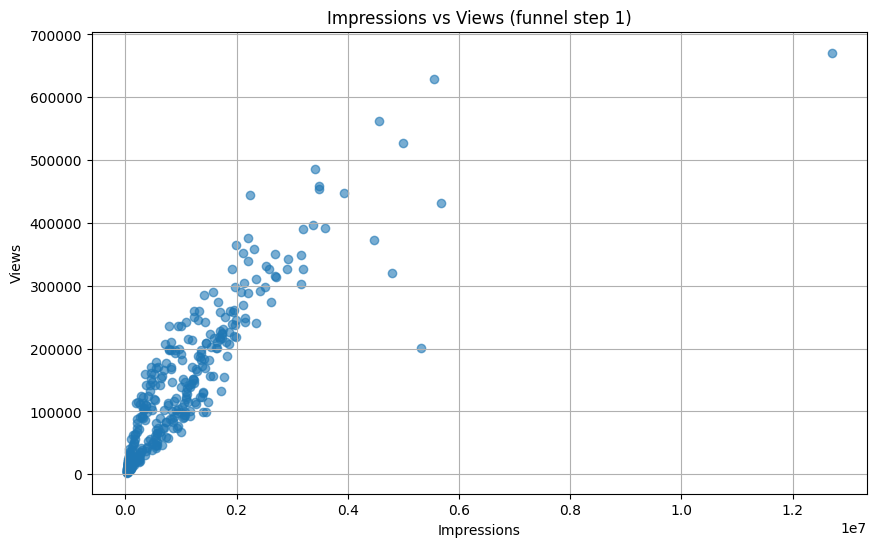

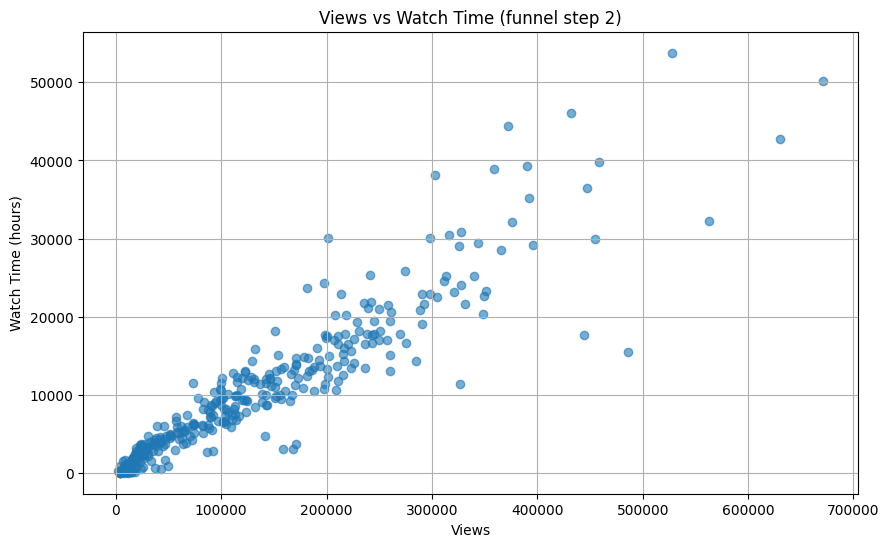

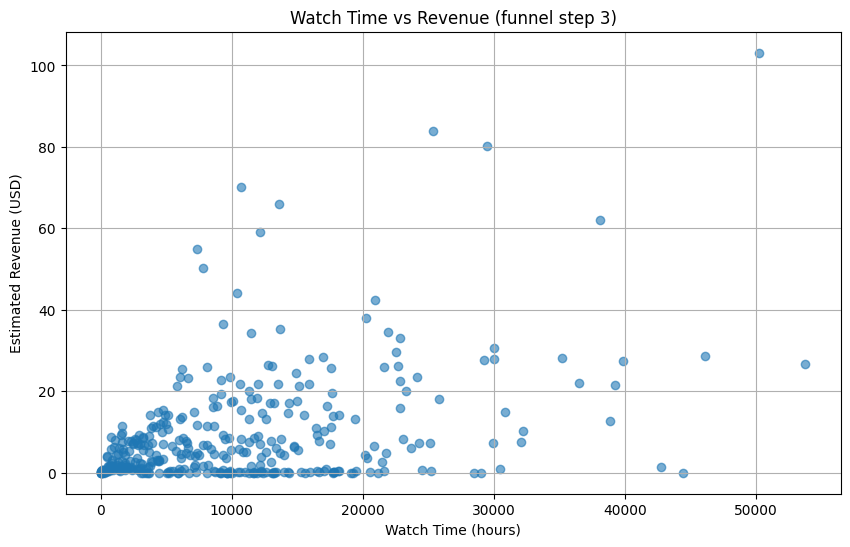

Median revenue by DayOfWeek x Hour (table):


publish_hour,0
publish_dow,
Friday,4.3785
Monday,5.7605
Saturday,2.9880
Sunday,1.4910
Thursday,5.0960
Tuesday,6.9910
Wednesday,4.2740


In [ ]:
# ================ 4) Exploratory Analysis ================
# 4.1 Distributions (Duration, Views, Revenue)
fig, axes = plt.subplots(1,3, figsize=(18,5))
axes[0].hist(df["Video Duration"], bins=30)
axes[0].set_title("Video Duration (minutes)")
axes[1].hist(df[views], bins=30)
axes[1].set_title("Views")
axes[2].hist(df[rev_est], bins=30)
axes[2].set_title("Estimated Revenue (USD)")
plt.show()

# 4.2 Funnel sanity: Impressions -> Views -> Watch Time -> Revenue
plt.scatter(df[impr], df[views], alpha=0.6)
plt.xlabel("Impressions")
plt.ylabel("Views")
plt.title("Impressions vs Views (funnel step 1)")
plt.show()

plt.scatter(df[views], df[watch_hr], alpha=0.6)
plt.xlabel("Views")
plt.ylabel("Watch Time (hours)")
plt.title("Views vs Watch Time (funnel step 2)")
plt.show()

plt.scatter(df[watch_hr], df[rev_est], alpha=0.6)
plt.xlabel("Watch Time (hours)")
plt.ylabel("Estimated Revenue (USD)")
plt.title("Watch Time vs Revenue (funnel step 3)")
plt.show()

# 4.3 Best time to publish (heatmap-like pivot)
pivot_time = df.pivot_table(index="publish_dow", columns="publish_hour",
                            values=rev_est, aggfunc="median")
pivot_time = pivot_time.fillna(0)
print("Median revenue by DayOfWeek x Hour (table):")
display(pivot_time)


In [ ]:
# ================ 5) Feature Set Assembly ================
numeric_features = [
    "Video Duration",
    "Days Since Publish",
    "Revenue per 1000 Views (USD)",
    "Playback-Based CPM (USD)", "CPM (USD)",
    "Ad Impressions",
    "Watch Page Ads Revenue (USD)", "YouTube Premium (USD)",
    "Transactions", "Revenue from Transactions (USD)",
    "Reactions", "Chat Messages Count", "Reminders Set",
    "Stream Hours", "Remix Views", "Remix Count",
    "New Comments", "Shares", "Like Rate (%)", "Dislikes", "Likes",
    "Unsubscribes", "New Subscribers",
    "Orders", "Total Sales Volume (USD)",
    "End Screen Click-Through Rate (%)", "End Screen Impressions", "End Screen Clicks",
    "Teaser Click-Through Rate (%)", "Teaser Impressions", "Teaser Clicks",
    "Card Click-Through Rate (%)", "Card Impressions", "Card Clicks",
    "Views per Playlist Start", "Playlist Views", "Playlist Watch Time (hours)",
    "Clip Watch Time (hours)", "Clip Views",
    "YouTube Premium Watch Time (hours)", "YouTube Premium Views",
    "Returning Viewers", "New Viewers", "Average Views per User",
    "Unique Viewers", "Watched (Not Skipped) (%)", "Feed Impressions",
    "Average View Percentage (%)", "Average View Duration",
    "Views", "Watch Time (hours)", "Subscribers", "Impressions",
    "Video Thumbnail CTR (%)",
    # engineered
    "watch_minutes_per_view", "avg_view_pct", "avg_view_dur_sec",
    "duration_minutes", "retention_vs_length",
    "ctr_ratio", "impr_to_view_rate", "views_per_unique",
    "revenue_per_view", "watch_time_per_view_h",
    "engagement_count", "engagement_rate_pct",
    "ads_rev_ratio", "premium_rev_ratio", "transaction_rev_ratio",
    "rpm_calc_usd"
]

# Keep only those that exist (defensive)
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = ["publish_dow"]  # already categorical

X_base = df[numeric_features + categorical_features].copy()

# Targets
y_rev  = df[rev_est].values
y_subs = df["New Subscribers"].values


In [ ]:
# ================ 6) Preprocess & Split ================
num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", num_pipe, numeric_features),
    ("cat", cat_pipe, categorical_features)
], remainder="drop")

X = X_base  # features frame

X_train, X_test, y_rev_train, y_rev_test = train_test_split(
    X, y_rev, test_size=0.2, random_state=42
)

_, _, y_subs_train, y_subs_test = train_test_split(
    X, y_subs, test_size=0.2, random_state=42
)


In [ ]:
# ================ 7) Model Zoo & CV (Revenue) ================
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=5.0, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    pipe = Pipeline([
        ("pre", pre),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2   = r2_score(y_test, pred)

    # CV on train for stability
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse = -cross_val_score(pipe, X_train, y_train,
                               scoring="neg_mean_squared_error", cv=cv).mean()
    cv_rmse = np.sqrt(cv_rmse)

    return pipe, rmse, r2, cv_rmse

results_rev = []
fitted_pipes_rev = {}

for name, mdl in models.items():
    pipe, rmse, r2, cv_rmse = evaluate_model(name, mdl, X_train, y_rev_train, X_test, y_rev_test)
    results_rev.append((name, rmse, r2, cv_rmse))
    fitted_pipes_rev[name] = pipe

res_df = pd.DataFrame(results_rev, columns=["Model", "RMSE_test", "R2_test", "CV_RMSE_train"])
print("Revenue prediction — model comparison:")
display(res_df.sort_values("RMSE_test"))
best_rev_name = res_df.sort_values("RMSE_test").iloc[0]["Model"]
print("Best (Revenue):", best_rev_name)
best_rev_pipe = fitted_pipes_rev[best_rev_name]


Revenue prediction — model comparison:


,Model,RMSE_test,R2_test,CV_RMSE_train
0,Linear,0.000485,1.000000,0.000494
2,RandomForest,0.396664,0.998193,2.629266
3,GradientBoosting,0.450727,0.997667,2.532349
1,Ridge,0.704674,0.994297,1.167046


Best (Revenue): Linear


In [ ]:
# ================ 8) Model Zoo & CV (New Subscribers) ================
results_subs = {}
results_subs_list = []
fitted_pipes_subs = {}

for name, mdl in models.items():
    pipe, rmse, r2, cv_rmse = evaluate_model(name, mdl, X_train, y_subs_train, X_test, y_subs_test)
    results_subs_list.append((name, rmse, r2, cv_rmse))
    fitted_pipes_subs[name] = pipe

res_df_subs = pd.DataFrame(results_subs_list, columns=["Model", "RMSE_test", "R2_test", "CV_RMSE_train"])
print("New Subscribers prediction — model comparison:")
display(res_df_subs.sort_values("RMSE_test"))
best_subs_name = res_df_subs.sort_values("RMSE_test").iloc[0]["Model"]
print("Best (New Subscribers):", best_subs_name)
best_subs_pipe = fitted_pipes_subs[best_subs_name]


New Subscribers prediction — model comparison:


,Model,RMSE_test,R2_test,CV_RMSE_train
0,Linear,6.216925e-13,1.000000,1.262135e-12
1,Ridge,1.027460e+01,0.999426,2.200907e+01
3,GradientBoosting,2.213376e+01,0.997337,9.046161e+01
2,RandomForest,6.253877e+01,0.978736,1.207819e+02


Best (New Subscribers): Linear


from matplotlib import pyplot as plt
_df_0['RMSE_test'].plot(kind='hist', bins=20, title='RMSE_test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['R2_test'].plot(kind='hist', bins=20, title='R2_test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['CV_RMSE_train'].plot(kind='hist', bins=20, title='CV_RMSE_train')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='RMSE_test', y='R2_test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='R2_test', y='CV_RMSE_train', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE_test']
  ys = series['R2_test']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('RMSE_test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_test')
_ = plt.ylabel('R2_test')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE_test']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE_test'}, axis=1)
              .sort_values('RMSE_test', ascending=True))
  xs = counted['RMSE_test']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('RMSE_test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_test')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['CV_RMSE_train']
  ys = series['R2_test']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('CV_RMSE_train', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CV_RMSE_train')
_ = plt.ylabel('R2_test')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['CV_RMSE_train']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'CV_RMSE_train'}, axis=1)
              .sort_values('CV_RMSE_train', ascending=True))
  xs = counted['CV_RMSE_train']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('CV_RMSE_train', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CV_RMSE_train')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['RMSE_test'].plot(kind='line', figsize=(8, 4), title='RMSE_test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['R2_test'].plot(kind='line', figsize=(8, 4), title='R2_test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['CV_RMSE_train'].plot(kind='line', figsize=(8, 4), title='CV_RMSE_train')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='RMSE_test', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='R2_test', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='CV_RMSE_train', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# ================ 9) Permutation Importance (Interpretability) ================
def permutation_importance_df(pipe, X_sample, y_sample, n_repeats=10):
    # Run permutation importance
    result = permutation_importance(pipe, X_sample, y_sample,
                                    n_repeats=n_repeats, random_state=42)

    # Get feature names after preprocessing
    pre = pipe.named_steps["pre"]
    feat_names = []
    try:
        feat_names = pre.get_feature_names_out()
    except:
        feat_names = [f"feature_{i}" for i in range(result.importances_mean.shape[0])]

    # Safety: align lengths
    n = min(len(feat_names), len(result.importances_mean))
    feat_names = feat_names[:n]

    imp_df = pd.DataFrame({
        "feature": feat_names,
        "importance_mean": result.importances_mean[:n],
        "importance_std": result.importances_std[:n]
    }).sort_values("importance_mean", ascending=False)

    return imp_df

# Use a sample to speed up if needed
X_samp = X_test.copy()
y_rev_samp = y_rev_test.copy()

imp_rev = permutation_importance_df(best_rev_pipe, X_samp, y_rev_samp)
print("Top drivers (Revenue):")
display(imp_rev.head(15))

X_samp2 = X_test.copy()
y_subs_samp = y_subs_test.copy()
imp_subs = permutation_importance_df(best_subs_pipe, X_samp2, y_subs_samp)
print("Top drivers (New Subscribers):")
display(imp_subs.head(15))


Top drivers (Revenue):


,feature,importance_mean,importance_std
63,num__watch_time_per_view_h,4.865797e-12,1.019902e-11
54,num__watch_minutes_per_view,4.820322e-12,1.025796e-11
49,num__Views,1.773515e-12,1.364242e-13
40,num__YouTube Premium Views,1.364242e-12,4.067384e-13
50,num__Watch Time (hours),1.364242e-12,0.000000e+00
3,num__Playback-Based CPM (USD),1.318767e-12,3.183231e-13
62,num__revenue_per_view,1.273293e-12,2.728484e-13
69,num__rpm_calc_usd,1.273293e-12,2.728484e-13
53,num__Video Thumbnail CTR (%),1.045919e-12,5.002221e-13
35,num__Playlist Views,6.821210e-13,4.659774e-13


Top drivers (New Subscribers):


,feature,importance_mean,importance_std
51,num__Subscribers,0.470069,0.054911
22,num__New Subscribers,0.453066,0.051878
21,num__Unsubscribes,0.006678,0.000450
3,num__Playback-Based CPM (USD),0.000000,0.000000
0,num__Video Duration,0.000000,0.000000
1,num__Days Since Publish,0.000000,0.000000
2,num__Revenue per 1000 Views (USD),0.000000,0.000000
6,num__Watch Page Ads Revenue (USD),0.000000,0.000000
5,num__Ad Impressions,0.000000,0.000000
4,num__CPM (USD),0.000000,0.000000


In [ ]:
# ================ 10) What-if Simulator (Actionable Insights) ================
uplift_test = X_test.copy()

def simulate(pipe, X_df, ctr_pp_increase=1.0, avd_sec_increase=5.0):
    X_sim = X_df.copy()
    # Nudge CTR and AVD
    if "Video Thumbnail CTR (%)" in X_sim.columns:
        X_sim["Video Thumbnail CTR (%)"] = X_sim["Video Thumbnail CTR (%)"] + ctr_pp_increase
    if "Average View Duration" in X_sim.columns:
        X_sim["Average View Duration"] = X_sim["Average View Duration"] + avd_sec_increase
    return pipe.predict(X_sim)

# Revenue simulator
base_rev_pred = best_rev_pipe.predict(uplift_test)
ctr_plus_pred = simulate(best_rev_pipe, uplift_test, ctr_pp_increase=1.0, avd_sec_increase=0.0)
avd_plus_pred = simulate(best_rev_pipe, uplift_test, ctr_pp_increase=0.0, avd_sec_increase=5.0)

print("Avg predicted revenue (base):   ", np.mean(base_rev_pred).round(2))
print("Avg with +1pp CTR:              ", np.mean(ctr_plus_pred).round(2))
print("Avg with +5 sec AVD:            ", np.mean(avd_plus_pred).round(2))


Avg predicted revenue (base):    344.9
Avg with +1pp CTR:               344.9
Avg with +5 sec AVD:             344.9


In [ ]:
# ================ 11) Publish Schedule Insights ================
def best_slots(metric_col):
    tab = df.pivot_table(index="publish_dow", columns="publish_hour",
                         values=metric_col, aggfunc="median").fillna(0)
    top = tab.stack().sort_values(ascending=False).head(10)
    return tab, top

rev_tab, rev_top = best_slots("Estimated Revenue (USD)")
subs_tab, subs_top = best_slots("New Subscribers")

print("Top 10 Day/Hour slots by median Revenue:")
display(rev_top)

print("Top 10 Day/Hour slots by median New Subscribers:")
display(subs_top)


Top 10 Day/Hour slots by median Revenue:


,,0
publish_dow,publish_hour,
Tuesday,0,6.9910
Monday,0,5.7605
Thursday,0,5.0960
Friday,0,4.3785
Wednesday,0,4.2740
Saturday,0,2.9880
Sunday,0,1.4910


Top 10 Day/Hour slots by median New Subscribers:


,,0
publish_dow,publish_hour,
Monday,0,254.5
Sunday,0,241.0
Friday,0,223.0
Tuesday,0,213.0
Wednesday,0,186.0
Thursday,0,132.0
Saturday,0,121.0


In [ ]:
# ================ 12) Clean Summary Report ================
summary = {}

# 12.1 Best models and scores
summary["revenue_model"] = best_rev_name
summary["subs_model"]    = best_subs_name

# 12.2 Key drivers
summary["top5_revenue_drivers"] = list(imp_rev.head(5)["feature"])
summary["top5_subs_drivers"]    = list(imp_subs.head(5)["feature"])

# 12.3 Actionable levers (what-if deltas)
summary["avg_pred_rev_base"]  = float(np.mean(base_rev_pred))
summary["avg_pred_rev_ctr+1"] = float(np.mean(ctr_plus_pred))
summary["avg_pred_rev_avd+5"] = float(np.mean(avd_plus_pred))

# 12.4 Best slots
summary["best_rev_slots"]  = rev_top.head(5).to_dict()
summary["best_subs_slots"] = subs_top.head(5).to_dict()

pd.Series(summary)


,0
revenue_model,Linear
subs_model,Linear
top5_revenue_drivers,"[num__watch_time_per_view_h, num__watch_minute..."
top5_subs_drivers,"[num__Subscribers, num__New Subscribers, num__..."
avg_pred_rev_base,344.90411
avg_pred_rev_ctr+1,344.90411
avg_pred_rev_avd+5,344.90411
best_rev_slots,"{('Tuesday', 0): 6.991, ('Monday', 0): 5.7605,..."
best_subs_slots,"{('Monday', 0): 254.5, ('Sunday', 0): 241.0, (..."
